# Navnet 2

Navnet version 2 approach combining self-supervised retrospective analysis, AE based anomaly detection, and patch navnet. The AE tries to predict what the right image sees based on a slightly larger patch from the left image and knowledge about where it was taken from.

In [1]:
import utils
train_path = "/home/michael/Desktop/BytesDB_train/"
test_path = "/home/michael/Desktop/BytesDB_valid/"

## Using Pandas for Dataloading and Management, New Data Management Class

In [2]:
train_data = utils.BytesDataset(train_path)
test_data = utils.BytesDataset(test_path)

## Batch Handling

In [36]:
import random
import torch
import matplotlib.pyplot as plt

# returns right patch, right image, left patch, left image, position of center of image patch in image 

# perform rebalancing as well (IMPLMENT ROBOT WIDTH Calcs + STEREO later)
def batch_generator(dataset, right_crop_shape=(3,10,10), left_crop_shape=(3,20,20), image_shape=(3,180,320), max_forward_prediction=30, collision_buffering=35, robot_width=0.8, batch_size=16):
    while True:
        
        # create memory for training data
        
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        
        left_crops = torch.zeros((batch_size, left_crop_shape[0], left_crop_shape[1], left_crop_shape[2]))
        left_masks = torch.zeros((batch_size, left_crop_shape[0], left_crop_shape[1], left_crop_shape[2]))

        right_crops = torch.zeros((batch_size, right_crop_shape[0], right_crop_shape[1], right_crop_shape[2])) 
        right_masks = torch.zeros((batch_size, right_crop_shape[0], right_crop_shape[1], right_crop_shape[2])) 
        
        positions = torch.zeros((batch_size, 2)) # center position of crop taken from image
        
        i = 0
        while i < batch_size:
            
            rand_source = random.randint(0, len(dataset.data)-1)
            if dataset.index_exists(rand_source) and dataset.index_exists(rand_source+1):
                rand_target = random.randint(rand_source+1, rand_source+max_forward_prediction+1)
                target = min(rand_target, dataset.get_next_break(rand_source)-collision_buffering-1)
                if target - rand_source > 0:
                    try:
                        position_3d = dataset.reference_target_from_source(rand_source, target)
                        point = utils.project_to_image(position_3d)
                        if point[0] < image_shape[2] - left_crop_shape[2]//2 and point[0] > left_crop_shape[2]//2 and point[1] < image_shape[1] - left_crop_shape[1]//2 and point[1] > left_crop_shape[1]//2:
                            
                            left_image = dataset.read_torch_image(rand_source)
                            crop_left = left_image[:,point[1]-left_crop_shape[1]//2:point[1]+left_crop_shape[1]//2, point[0]-left_crop_shape[2]//2:point[0]+left_crop_shape[2]//2]                
                            right_image = dataset.read_torch_image(rand_source, True)
                            crop_right = right_image[:,point[1]-right_crop_shape[1]//2:point[1]+right_crop_shape[1]//2, point[0]-right_crop_shape[2]//2:point[0]+right_crop_shape[2]//2] 
                            
                            path = dataset.path_source_to_target(rand_source, target)
                            mask_left = torch.from_numpy(utils.make_mask_from_path(path, robot_width=0.6)).transpose(0,2).transpose(1,2)
                            mask_right = torch.from_numpy(utils.make_mask_from_path(path, robot_width=0.6, right=True)).transpose(0,2).transpose(1,2)

                            left_crops[i] = crop_left
                            left_masks[i] = mask_left[:,point[1]-left_crop_shape[1]//2:point[1]+left_crop_shape[1]//2, point[0]-left_crop_shape[2]//2:point[0]+left_crop_shape[2]//2]
                            left_images[i] = left_image

                            right_crops[i] = crop_right
                            right_masks[i] = mask_right[:,point[1]-right_crop_shape[1]//2:point[1]+right_crop_shape[1]//2, point[0]-right_crop_shape[2]//2:point[0]+right_crop_shape[2]//2] 
                            right_images[i] = right_image

                            positions[i] = torch.tensor([point[0], point[1]])

                            i += 1
                    except Exception as e:
                        pass
                        
        yield right_crops, right_masks, right_images, left_crops, left_masks, left_images, positions
        

In [52]:
batch = next(batch_generator(train_data, left_crop_shape=(3,32,32)))

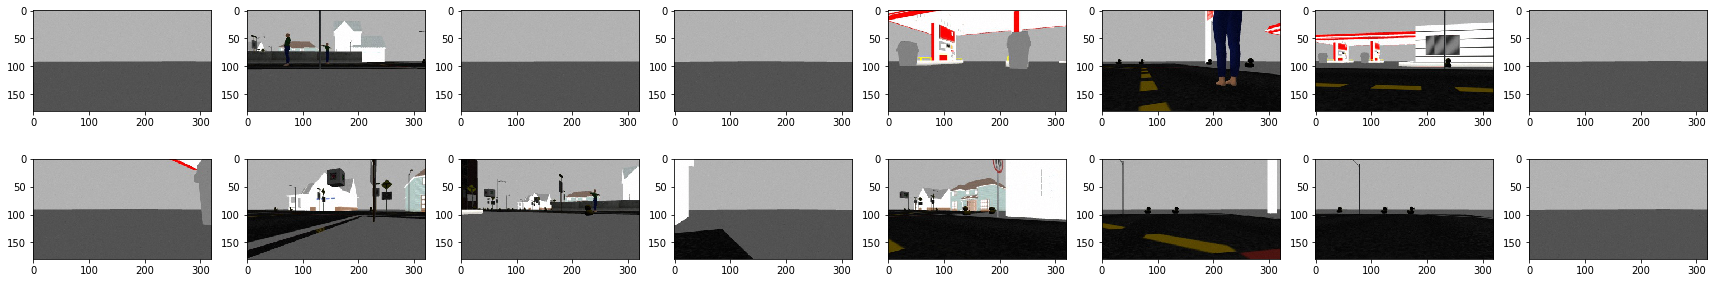

In [53]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(batch[5][i]))

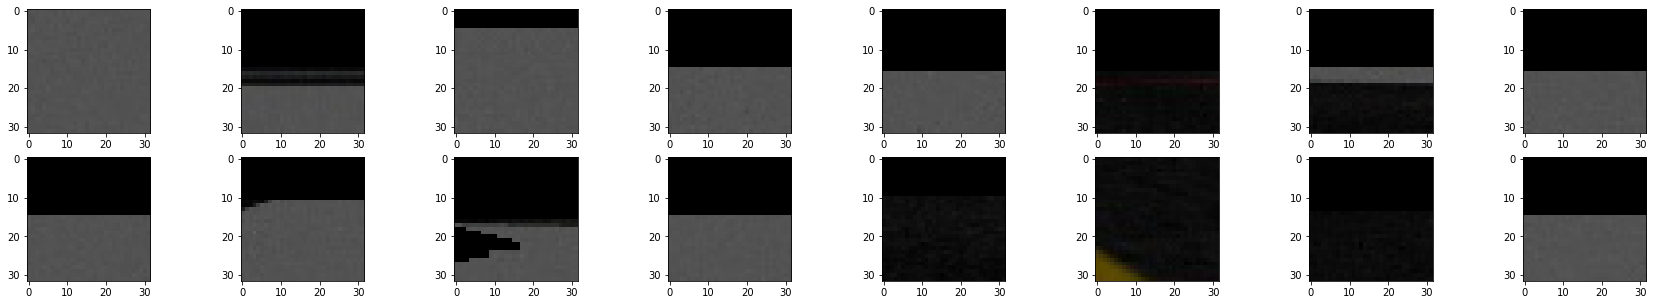

In [54]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(batch[3][i]*batch[4][i])*batch[4][i].transpose(0,2).transpose(0,1).numpy())

## Create the autoencoder model

In [55]:
import torch.nn as nn

def same_padding(stride, width, height, filter_size):
    pad_w = ((stride-1)*width-stride+filter_size)/2
    pad_h = ((stride-1)*height-stride+filter_size)/2
    return (int(pad_h),int(pad_w))

class NavNet(nn.Module):
    def __init__(self, input_shape=(3, 64, 64)):
        super(NavNet, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//4,input_shape[1]//4,5)),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        
        self.decoder = torch.nn.Sequential(
            nn.UpsamplingNearest2d(input_shape[2]//2),
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2]//2,input_shape[1]//2,5)),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(input_shape[2]),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],1))
        )
    
    def forward(self, img):
        embedding = self.encoder(img)
        output = self.decoder(embedding)
        return output
        

## Train the model

In [29]:
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


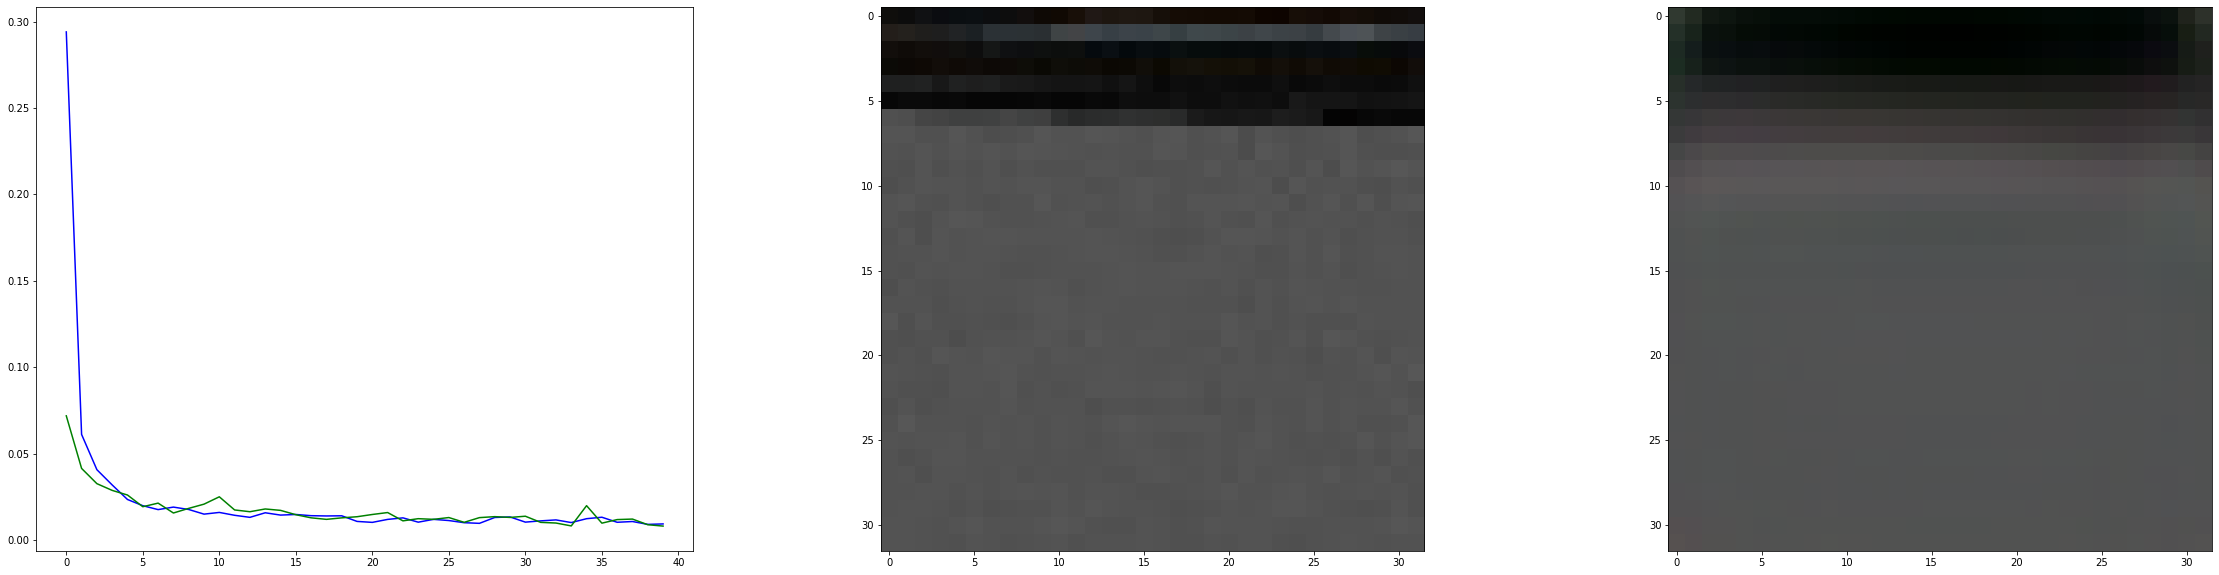

In [56]:
num_epochs = 40
train_steps_per_epoch = 50
test_steps_per_epoch = 10
batch_size = 16

left_crop_size = (3,32,32)
right_crop_size = (3,10,10)
collision_buffer = 35
max_forward_pred = 30

# Make Model

navnet = NavNet(input_shape=left_crop_size).to(device)

optimizer = torch.optim.Adam(navnet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_batch_gen = batch_generator(train_data, right_crop_shape=right_crop_size, left_crop_shape=left_crop_size, image_shape=(3,180,320), max_forward_prediction=max_forward_pred, \
                                  collision_buffering=collision_buffer, robot_width=0.8, batch_size=batch_size)
test_batch_gen = batch_generator(test_data, right_crop_shape=right_crop_size, left_crop_shape=left_crop_size, image_shape=(3,180,320), max_forward_prediction=max_forward_pred, \
                                 collision_buffering=collision_buffer, robot_width=0.8, batch_size=batch_size)


from IPython.display import clear_output


train_loss = []
test_loss = []
for epoch in range(num_epochs):
    
    avg_train_loss = 0
    avg_test_loss = 0
    
    disp_output = None
    disp_input = None
    
    for step in range(train_steps_per_epoch):
        optimizer.zero_grad()
        right_crops, right_masks, right_images, left_crops, left_masks, left_images, positions = next(train_batch_gen)
        output = navnet(left_crops.to(device))
        loss = criterion(output*left_masks.to(device), left_crops.to(device)*left_masks.to(device))
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        
    avg_train_loss /= train_steps_per_epoch
    train_loss.append(avg_train_loss)
    
    for step in range(test_steps_per_epoch):
        right_crops, right_masks, right_images, left_crops, left_masks, left_images, positions = next(test_batch_gen)
        output = navnet(left_crops.to(device))
        loss = criterion(output*left_masks.to(device), left_crops.to(device)*left_masks.to(device))
        avg_test_loss += loss.item()
        
        # additional visualization ability
        disp_output = output
        disp_input = left_crops
        
    avg_test_loss /= test_steps_per_epoch
    test_loss.append(avg_test_loss)
    
    # Plot the losses in realtime
    
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(40,10))
    fig.add_subplot(1,3,1)
    
    plt.plot(train_loss,  color='blue', label='train loss')
    plt.plot(test_loss,  color='green', label='test loss')
    
    fig.add_subplot(1,3,2)
    plt.imshow(utils.torch_image_to_cv_image(disp_input[0]))
    
    fig.add_subplot(1,3,3)
    plt.imshow(utils.torch_image_to_cv_image(disp_output[0].cpu().detach()))
    
    plt.show()

## Test the model

In [67]:
import time, cv2
import numpy as np

patch_side_len = 32
threshold = 0.4

navnet.eval()
for i in range(1, len(test_data.data)):
    img = train_data.read_torch_image(i)
    if len(img) > 0:
        cv_image = utils.torch_image_to_cv_image(img)

        for width in range(0,320,patch_side_len): # from 0 - 320
            for height in range(84, 180, patch_side_len): # from 100 - 180
                
                score = 0
                
                crop = img[:,height:height+patch_side_len, width:width+patch_side_len].unsqueeze(0).to(device)
                crop_image = cv_image[height:height+patch_side_len, width:width+patch_side_len,:]
                model_output = navnet(crop)
                                
                loss = torch.nn.functional.mse_loss(model_output, crop).item()
                
                if loss > threshold:
                    score = 1
                else:
                    score = 0
                                
                color_mask = np.zeros((patch_side_len,patch_side_len,3), np.float32)
                red = np.zeros((patch_side_len,patch_side_len))
                red.fill(loss/threshold)
                green = np.zeros((patch_side_len,patch_side_len))
                green.fill(1-loss/threshold)
                color_mask[:,:,0] = red
                color_mask[:,:,1] = green
                crop_image = cv2.addWeighted(crop_image,0.7,color_mask,0.3,0)  
                cv_image[height:height+patch_side_len, width:width+patch_side_len,:] = crop_image

        cv2.imshow('image', cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB))
        cv2.waitKey(1)

## Save the model

In [65]:
# Standard pytorch model saving/loading
name = "navnet-ae-path-predictor-v2"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>